In [1]:
# Ground modules
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from Bio import SeqIO
from itertools import product
import random
import matplotlib.pyplot as plt
from collections import Counter
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import logging
import subprocess
from multiprocessing.pool import ThreadPool
import joblib

# SCikitlearn modules :
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report , roc_auc_score

# Scipy modules : 
from scipy.stats import fisher_exact

In [3]:
import json

path_seqbased = "/media/concha-eloko/Linux/PPT_clean/Seqbased_model"
path_db = f"{path_seqbased}/TropiSeq/TropiSeq_0.75.db"

dico_cluster = json.load(open(f"{path_seqbased}/dico_cluster.cdhit__0.75.json"))
dico_cluster_r = {ref_dpo : key_dpo for key_dpo,list_dpo in dico_cluster.items() for ref_dpo in list_dpo}


In [2]:
# *****************************************************************************
# Load the Dataframes :
path_work = "/media/concha-eloko/Linux/PPT_clean"

    # Open the DF
DF_info = pd.read_csv(f"{path_work}/TropiGATv2.final_df_v2.tsv", sep = "\t" ,  header = 0)
DF_info = DF_info.drop_duplicates(subset = ["Protein_name"])

df_prophages = DF_info.drop_duplicates(subset = ["Phage"], keep = "first")
dico_prophage_info = {row["Phage"] : {"prophage_strain" : row["prophage_id"] , "ancestor" : row["Infected_ancestor"]} for _,row in df_prophages.iterrows()}

def get_filtered_prophages(prophage) :
    combinations = []
    to_exclude = set()
    to_keep = set()
    to_keep.add(prophage)
    df_prophage_group = DF_info[(DF_info["prophage_id"] == dico_prophage_info[prophage]["prophage_strain"]) & (DF_info["Infected_ancestor"] == dico_prophage_info[prophage]["ancestor"])]
    if len(df_prophage_group) == 1 :
        pass
    else :
        depo_set = set(df_prophage_group[df_prophage_group["Phage"] == prophage]["domain_seq"].values)
        for prophage_tmp in df_prophage_group["Phage"].unique().tolist() :
            if prophage_tmp != prophage :
                tmp_depo_set = set(df_prophage_group[df_prophage_group["Phage"] == prophage_tmp]["domain_seq"].values)
                if depo_set == tmp_depo_set :
                    to_exclude.add(prophage_tmp)
                else :
                    if tmp_depo_set not in combinations :
                        to_keep.add(prophage_tmp)
                        combinations.append(tmp_depo_set)
                    else :
                        to_exclude.add(prophage_tmp)
    return df_prophage_group , to_exclude , to_keep

good_prophages = set()
excluded_prophages = set()

for prophage, info_prophage in tqdm(dico_prophage_info.items()) :
    if prophage not in excluded_prophages and prophage not in good_prophages:
        _, excluded_members , kept_members = get_filtered_prophages(prophage)
        good_prophages.update(kept_members)
        excluded_prophages.update(excluded_members)

DF_info_lvl_0_filtered = DF_info[DF_info["Phage"].isin(good_prophages)]
DF_info_lvl_0_final = DF_info_lvl_0_filtered[~DF_info_lvl_0_filtered["KL_type_LCA"].str.contains("\\|")]

DF_info_lvl_0 = DF_info_lvl_0_final.copy()



100%|████████████████████████████████████| 15981/15981 [00:23<00:00, 681.36it/s]


In [3]:
DF_info_lvl_0

,Phage,Protein_name,KL_type_LCA,Infected_ancestor,index,Dataset,seq,domain_seq,1,2,...,1272,1273,1274,1275,1276,1277,1278,1279,1280,prophage_id
0,GCF_902164905.1__phage1,GCF_902164905.1__phage1__34,KL41,GCF_902164905.1,minibatch__460,minibatch,MPATPQDRLYGLTTSVAVKPPVFISVDYDVARFGEQTITSKTPTDE...,QDRLYGLTTSVAVKPPVFISVDYDVARFGEQTITSKTPTDERTITT...,0.025276,0.053137,...,-0.011464,0.081105,0.012011,0.042917,0.009402,0.093175,-0.080562,0.000897,0.111854,prophage_11309
4,GCF_017310305.1__phage5,GCF_017310305.1__phage5__1353,KL30,n4996,minibatch__1084,minibatch,MTVSTQVSRNEYTGNGATTQYDFTFRILDKSHLLVQTMDTSENIVT...,VSTQVSRNEYTGNGATTQYDFTFRILDKSHLLVQTMDTSENIVTLT...,0.004905,0.040896,...,-0.040657,0.087288,0.022292,0.024434,0.025246,0.083449,-0.123537,0.047648,0.061250,prophage_5
10,GCF_001701985.1__phage2,GCF_001701985.1__phage2__357,KL30,n4988,minibatch__1084,minibatch,MTVSTQVSRNEYTGNGATTQYDFTFRILDKSHLLVQTMDTSENIVT...,VSTQVSRNEYTGNGATTQYDFTFRILDKSHLLVQTMDTSENIVTLT...,0.004905,0.040896,...,-0.040657,0.087288,0.022292,0.024434,0.025246,0.083449,-0.123537,0.047648,0.061250,prophage_6465
12,GCF_001611095.1__phage5,GCF_001611095.1__phage5__1365,KL30,n49894989,minibatch__1084,minibatch,MTVSTQVSRNEYTGNGATTQYDFTFRILDKSHLLVQTMDTSENIVT...,VSTQVSRNEYTGNGATTQYDFTFRILDKSHLLVQTMDTSENIVTLT...,0.004905,0.040896,...,-0.040657,0.087288,0.022292,0.024434,0.025246,0.083449,-0.123537,0.047648,0.061250,prophage_5
15,GCF_902156555.1__phage3,GCF_902156555.1__phage3__511,KL30,GCF_902156555.1,minibatch__1084,minibatch,MTVSTQVSRNEYTGNGATTQYDFTFRILDKSHLLVQTMDTSENIVT...,VSTQVSRNEYTGNGATTQYDFTFRILDKSHLLVQTMDTSENIVTLT...,0.004905,0.040896,...,-0.040657,0.087288,0.022292,0.024434,0.025246,0.083449,-0.123537,0.047648,0.061250,prophage_1828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21342,GCF_900506765.1__phage17,GCF_900506765.1__phage17__90,KL149,GCF_900506765.1,anubis_return__4216,anubis_return,MMTTLNEHPQWESDIYLIKRSDLVAGGRGGIANMQAQQLANRTAFL...,NRRWFRRFTGNIRAEWSGIHDLSQSSAPVDSYIYRLLLASAVGSPD...,0.053704,0.083858,...,0.032803,0.109572,0.010032,0.024949,0.094129,0.028693,-0.061396,0.006824,0.046220,prophage_15598
21344,GCF_003255785.1__phage1,GCF_003255785.1__phage1__10,KL127,GCF_003255785.1,anubis_return__4239,anubis_return,MNGLNHNALTCSAVPIPPWERSLQTVEAQPYFSVSQASLVLEGIVF...,MNGLNHNALTCSAVPIPPWERSLQTVEAQPYFSVSQASLVLEGIVF...,0.010626,-0.025389,...,0.045372,0.009262,-0.008319,-0.050856,0.034115,0.101663,-0.108278,-0.135629,0.102486,prophage_3577
21346,GCF_002186895.1__phage9,GCF_002186895.1__phage9__5,KL57,GCF_002186895.1,anubis_return__4260,anubis_return,MRYRFIALALCLLSGSKVAISAGFDCSLANLSPTEKTICSNEYLSG...,ITDSPWLVKKIFSSDSFEGGINLEGMNVSSILTYQEIKNDLYIYIS...,0.073450,0.046651,...,0.035302,0.012151,0.003563,-0.022575,0.014130,0.063376,-0.050646,-0.085156,-0.010849,prophage_6002
21347,GCF_004312845.1__phage3,GCF_004312845.1__phage3__38,KL9,GCF_004312845.1,anubis_return__4275,anubis_return,MAILITGKSMTRLPESSSWEEEIELITRSERVAGGLDGPANRPLKS...,DAVIRRDLASDKGTSGVGKLGDKPLVAISYYKSKGQSDQDAVQAAF...,0.032196,0.048856,...,-0.016331,0.084711,0.056063,0.001793,0.073958,0.090169,-0.060105,0.023726,0.086452,prophage_12656


In [34]:
depo_df = DF_info_lvl_0.drop_duplicates(subset = ["index"])

In [38]:
info_embeddings_df = depo_df[[str(i) for i in list(range(1, 1281))]]
info_embeddings_df.set_index(depo_df["index"], inplace = True)
info_embeddings_df = info_embeddings_df[info_embeddings_df.index.isin(dico_cluster_r)]

In [48]:
#depo_cluster_list = [dico_cluster_r[dpo] if dpo in dico_cluster_r else "other" for dpo in embeddings_df.index]
depo_cluster_list = [dico_cluster_r[dpo] for dpo in embeddings_df.index]

# Create a colormap
cmap = plt.cm.get_cmap('tab20')  
color_dict = {obj: cmap(i / len(dico_cluster)) for i, obj in enumerate(dico_cluster)}
colors_list = [color_dict[cluster] for _,cluster in enumerate(depo_cluster_list)]


/tmp/ipykernel_42558/1071376698.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20')


In [52]:
colors_list

[(0.6823529411764706, 0.7803921568627451, 0.9098039215686274, 1.0),
 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
 (1.0, 0.4980392156862745, 0.054901960784313725, 1.0),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353, 1.0),
 (0.7803921568627451, 0.7803921568627451, 0.7803921568627451, 1.0),
 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
 (1.0, 0.7333333333333333, 0.47058823529411764, 1.0),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1.0),
 (1.0, 0.4980392156862745, 0.054901960784313725, 1.0),
 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
 (1.0, 0.4980392156862745, 0.054901960784313725, 1.0),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274, 1.0),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745, 1.0),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274, 1.0),
 (0.09019607843137255, 0.74509

In [43]:
strict_embeddings_df = info_embeddings_df.reset_index()
strict_embeddings_df.drop(columns=["index"], inplace=True)
strict_embeddings_df

,1,2,3,4,5,6,7,8,9,10,...,1271,1272,1273,1274,1275,1276,1277,1278,1279,1280
0,0.025276,0.053137,0.002901,-0.008421,-0.090702,0.014603,-0.010843,-0.083603,0.049112,0.015829,...,0.006108,-0.011464,0.081105,0.012011,0.042917,0.009402,0.093175,-0.080562,0.000897,0.111854
1,0.004905,0.040896,-0.027048,0.009617,-0.110036,-0.006582,-0.003974,-0.091815,0.029156,0.045741,...,0.012836,-0.040657,0.087288,0.022292,0.024434,0.025246,0.083449,-0.123537,0.047648,0.061250
2,-0.003624,-0.032987,-0.030619,0.069205,-0.069458,-0.010844,0.006239,-0.157970,0.019729,0.083344,...,-0.026931,-0.075218,-0.010726,0.008995,-0.001741,-0.103979,0.119088,-0.124593,0.011745,0.147883
3,0.038219,0.037305,0.003638,-0.019642,-0.092136,0.024631,-0.069517,0.004469,0.021873,0.075604,...,0.018884,0.010699,0.013225,0.038260,-0.001471,0.040612,0.066368,-0.078655,0.031434,0.080821
4,0.008351,0.003703,-0.037393,-0.024124,-0.076083,0.038229,0.026381,-0.067795,0.085511,0.030692,...,-0.021656,0.019730,0.102699,0.003058,0.044005,0.042251,0.042038,-0.098792,0.009710,0.120689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4029,0.053704,0.083858,0.006838,-0.013659,-0.085406,0.013867,0.021987,-0.024287,0.083927,-0.012246,...,0.041974,0.032803,0.109572,0.010032,0.024949,0.094129,0.028693,-0.061396,0.006824,0.046220
4030,0.010626,-0.025389,0.020418,-0.010070,-0.110296,0.019740,0.020795,-0.081496,0.007390,0.078431,...,0.068354,0.045372,0.009262,-0.008319,-0.050856,0.034115,0.101663,-0.108278,-0.135629,0.102486
4031,0.073450,0.046651,0.010577,0.037751,-0.060665,-0.014328,-0.025469,-0.058647,-0.045293,0.022518,...,0.049351,0.035302,0.012151,0.003563,-0.022575,0.014130,0.063376,-0.050646,-0.085156,-0.010849
4032,0.032196,0.048856,-0.017520,-0.048653,-0.075183,0.013526,-0.035467,-0.102460,0.021035,0.021758,...,0.004865,-0.016331,0.084711,0.056063,0.001793,0.073958,0.090169,-0.060105,0.023726,0.086452



***
### T-SNE plot :

In [ ]:
df_embeddings = df_tsne_v2.reset_index()
df_embeddings.drop(columns=[0], inplace=True)
df_embeddings

/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_spar

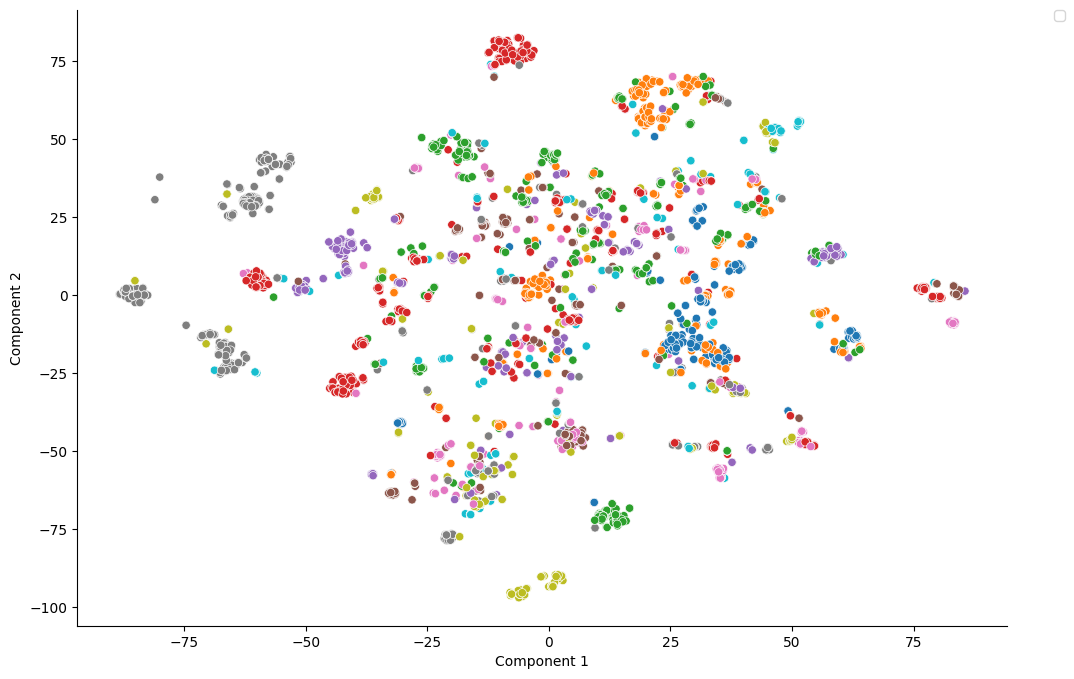

In [57]:
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(strict_embeddings_df)

# Create a new DataFrame to store 2D embeddings and labels
df_2d = pd.DataFrame(embeddings_2d, columns=['Component 1', 'Component 2'], index=info_embeddings_df.index)

# Create a colormap
cmap = plt.cm.get_cmap('tab')  
color_dict = {obj: cmap(i / len(dico_cluster)) for i, obj in enumerate(dico_cluster)}
colors_list = [color_dict[cluster] for _,cluster in enumerate(depo_cluster_list)]

# Plot the t-SNE representation with labels
plt.figure(figsize=(12, 8))
ax = sns.scatterplot(data=df_2d, x='Component 1', y='Component 2', color=colors_list)

# Customize the tick positions and labels
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

# Remove the top and right spines (borders)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set the axis labels
plt.xlabel('Component 1')
plt.ylabel('Component 2')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig(f'{path_work}/tsne_depos.PPT_TropiSeq.svg', format='svg', bbox_inches='tight', dpi = 500)
plt.show()